## Bernoulli Naive Bayes Classifier

### Data Preprocessing
Loads the IMDB dataset using TensorFlow's Keras module, creating training and testing sets without the need for a separate validation set. It further maps numeric sequences to human-readable text.


In [2]:
m = 2500    # Number of words in the vocabulary
n = 200     # N most frequent words to skip
k = 0       # K least frequent words to skip

In [3]:
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())

index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Transforms the textual movie reviews into binary bag-of-words representations, indicating the presence (1) or absence (0) of words using scikit-learn's CountVectorizer.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = x_train_binary.toarray()
x_test_binary = x_test_binary.toarray()

### Visualization Functions

In [41]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_curve)


def evaluate_estimator(estimator, x_train, y_train, x_test, y_test, splits=5):
    train_accuracies, test_accuracies, train_precisions, test_precisions = [], [], [], []
    train_recall, test_recall, train_f1, test_f1 = [], [], [], []
    split_size = len(x_train) // splits

    for i in range(1, splits + 1):
        x_train_split, y_train_split = x_train[:i * split_size], y_train[:i * split_size]
        estimator.fit(x_train_split, y_train_split)

        train_pred, test_pred = estimator.predict(x_train_split), estimator.predict(x_test)

        train_accuracies.append(accuracy_score(y_train_split, train_pred))
        test_accuracies.append(accuracy_score(y_test, test_pred))

        train_precisions.append(precision_score(y_train_split, train_pred))
        test_precisions.append(precision_score(y_test, test_pred))

        train_recall.append(recall_score(y_train_split, train_pred))
        test_recall.append(recall_score(y_test, test_pred))

        train_f1.append(f1_score(y_train_split, train_pred))
        test_f1.append(f1_score(y_test, test_pred))

    cm = confusion_matrix(y_test, test_pred)

    return {'estimator': estimator.__class__.__name__,
            'split_size': split_size,
            'splits': splits,
            'test_pred': test_pred,
            'train_accuracy': train_accuracies,
            'test_accuracy': test_accuracies,
            'train_precision': train_precisions,
            'test_precision': test_precisions,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'confusion_matrix': cm}         


def plot_confusion_matrix(cm, title):
    """
    Creates a heatmap of the confusion matrix.

    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns:
      A heatmap of the confusion matrix.
    """
    
    cm_matrix = DataFrame(data=cm, columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])
    
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    ax.set_title(f'Confusion Matrix Heatmap for {title}')
    
    return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

def plot_metrics_table(evaluate_metrics):
    """
    Creates and displays a table of the train/test accuracies, precisions, recalls,
    and F1 scores for each split. 

    Arguments:
      evaluate_metrics: The dictionary containing the train/test data metrics.
    """
    num_splits = evaluate_metrics['splits']
    split_size = evaluate_metrics['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(evaluate_metrics[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_roc_curve(y_true, y_scores, label='Classifier'):
  """
  Plot the ROC curve for a binary classification model.

  Parameters:
    - y_true: True labels (ground truth).
    - y_scores: Predicted scores or probabilities for the positive class.
    - label (optional): Label for the classifier (default is 'Classifier').
  """
  
  fpr, tpr, thresholds = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

def plot_learning_curves(classification_data):
  """
  Visualize both normal and zoomed learning curves of accuracy, precision, recall, and F1 for training and testing sets.

  Arguments:
    classification_data: The dictionary containing the train/test data.
  """
  num_splits = classification_data['splits']
  split_size = classification_data['split_size']

  x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

  metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

  for metric in metrics:
      # Create a new figure for each metric
      plt.figure(figsize=(7, 4))

      # Plot normal learning curves
      plt.subplot(1, 2, 1)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric}')
      plt.xticks(x_values)
      plt.ylim(0.0 - 0.1, 1.0 + 0.1)
      plt.legend()

      # Plot zoomed learning curves
      plt.subplot(1, 2, 2)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric} (Zoomed In)')
      plt.xticks(x_values)

      # Calculate y-axis limits based on the range of y-values for each metric
      y_min = min(min(classification_data[f'train_{metric.lower()}']), min(classification_data[f'test_{metric.lower()}']))
      y_max = max(max(classification_data[f'train_{metric.lower()}']), max(classification_data[f'test_{metric.lower()}']))
      y_range = y_max - y_min
      plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

      plt.suptitle(f"Learning Curve for {classification_data['estimator']} - {metric}", fontsize=16)
      plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
      plt.tight_layout(rect=[0, 0, 1, 0.98])
      plt.show()

def plot_metrics_table_differences(classifier1_data, classifier2_data):
    """
    Creates and displays a table of the differences in train/test accuracies, precisions, recalls,
    and F1 scores between two classifiers for each split.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """
    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(classifier1_data[f'{data_type.lower()}_{metric.lower()}'], 2) - np.round(classifier2_data[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_learning_curve_differences(classifier1_data, classifier2_data):
    """
    Visualize the differences between two classifiers and their learning curves for accuracy, precision, recall, and F1.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """

    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']
    x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

    for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
        plt.figure(figsize=(8, 4))

        # Plot normal learning curves for both classifiers
        plt.subplot(1, 2, 1)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(metric)
        plt.ylim(0.0 - 0.1, 1.0 + 0.1)
        plt.legend()

        # Plot zoomed-in learning curves for both classifiers
        plt.subplot(1, 2, 2)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(f'{metric} (Zoomed In)')

        # Calculate y-axis limits based on the range of y-values for each metric
        y_min_cl1 = min(min(classifier1_data[f'train_{metric.lower()}']), min(classifier1_data[f'test_{metric.lower()}']))
        y_max_cl1 = max(max(classifier1_data[f'train_{metric.lower()}']), max(classifier1_data[f'test_{metric.lower()}']))
        y_min_cl2 = min(min(classifier2_data[f'train_{metric.lower()}']), min(classifier2_data[f'test_{metric.lower()}']))
        y_max_cl2 = max(max(classifier2_data[f'train_{metric.lower()}']), max(classifier2_data[f'test_{metric.lower()}']))
        y_min = min(y_min_cl1, y_min_cl2)
        y_max = max(y_max_cl1, y_max_cl2)
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

        plt.suptitle(f"{metric} Differences {classifier1_data['estimator']} - {classifier2_data['estimator']} (scikit)", fontsize=16)
        plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()


### Bernoulli Naive Bayes Classifier Implementation
This class implements a Bernoulli Naive Bayes classifier for binary sentiment analysis. The ***fit*** function trains the model, calculating prior and conditional probabilities with Laplace smoothing and log probabilities for stability. The ***predict*** function uses these probabilities to predict sentiment (positive or negative) based on input features.


In [54]:
class BernoulliNaiveBayes():
    def __init__(self):
        pass

    def fit(self, X, y):
        """
        Trains the Bernoulli Naive Bayes model by calculating prior and conditional log probabilities.

        Parameters:
        - X: Input feature matrix (binary values indicating feature presence/absence).
        - y: Binary class labels (1 for positive, 0 for negative).

        Returns:
        None
        """
        # Calculate the prior probability of each class (P(C=1) : positive and P(C=0) : negative)
        self.prob_pos = np.log((np.sum(y) + 1)/ (len(y) + 2))
        self.prob_neg = np.log(1 - (np.sum(y) + 1) / (len(y) + 2))

        # Calculate the probability of each feature for the given class
        # P(Xi=1|C=1) : probability of feature 1 given class 1
        self.prob_feature1_pos = np.log((np.sum(X[y == 1], axis = 0) + 1) / (np.sum(y) + 2))

        # P(Xi=0|C=1) : probability of feature 0 given class 1
        self.prob_feature0_pos = np.log(1.0 - (np.sum(X[y == 1], axis = 0) + 1) / (np.sum(y) + 2))
        
        # P(Xi=1|C=0) : probability of feature 1 given class 0
        self.prob_feature1_neg = np.log((np.sum(X[y == 0], axis = 0) + 1) / (len(y) - np.sum(y) + 2))

        # P(Xi=0|C=0) : probability of feature 0 given class 0
        self.prob_feature0_neg = np.log(1.0 - (np.sum(X[y == 0], axis = 0) + 1) / (len(y) - np.sum(y) + 2))

        return

    def predict(self, X):
        """
        Predicts the class labels based on input features.

        Parameters:
        - X: Input feature matrix (binary values indicating feature presence/absence).

        Returns:
        - pred: Predicted class labels (0 for negative, 1 for positive).
        """
        # Calculate the probability of each class for the given features
        tot_prob_pos = self.prob_pos + np.sum(self.prob_feature1_pos * X + self.prob_feature0_pos * (1 - X), axis=1)
        tot_prob_neg = self.prob_neg + np.sum(self.prob_feature1_neg * X + self.prob_feature0_neg * (1 - X), axis=1)

        # Predict the class with the higher probability
        pred = (tot_prob_pos > tot_prob_neg).astype(int)

        return pred

### Bernoulli Naive Bayes Classifier Evaluation Results

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.87,0.83,0.88,0.85,0.86,0.81,0.87,0.83
10000,0.86,0.84,0.87,0.85,0.86,0.83,0.87,0.84
15000,0.86,0.84,0.86,0.85,0.85,0.82,0.86,0.84
20000,0.85,0.84,0.86,0.85,0.84,0.82,0.85,0.83
25000,0.85,0.84,0.85,0.85,0.85,0.83,0.85,0.84


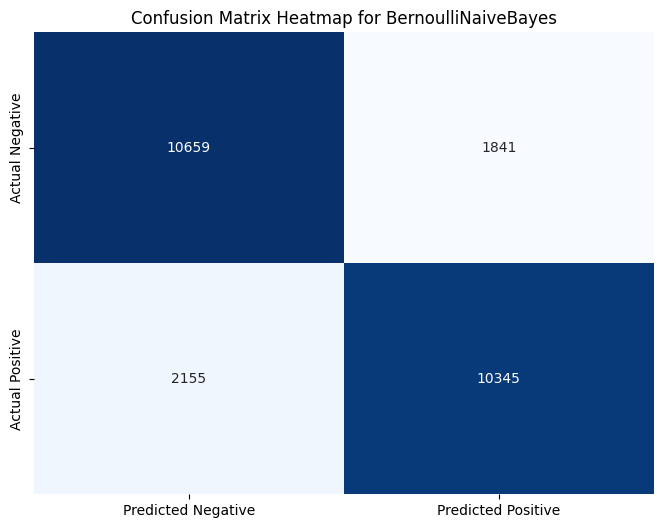

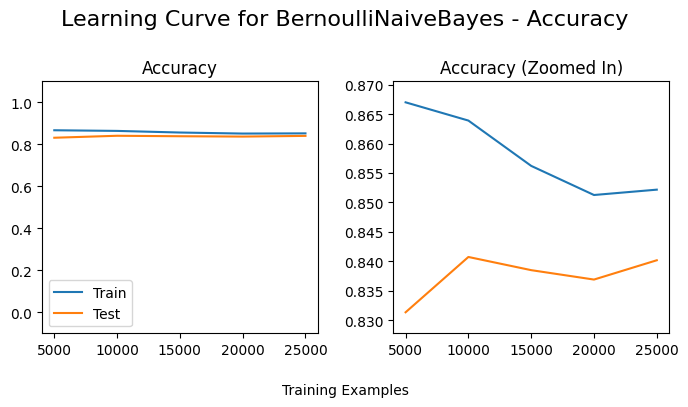

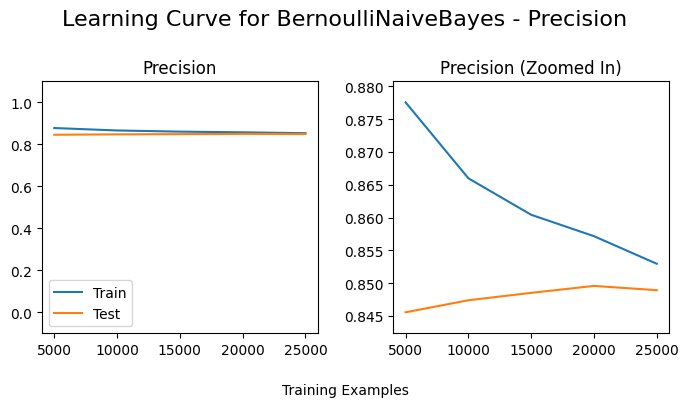

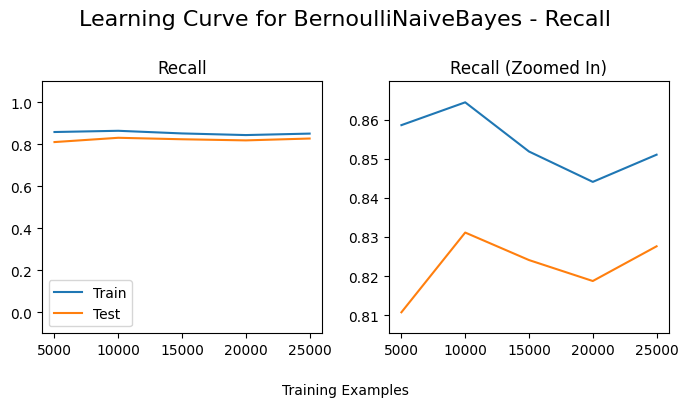

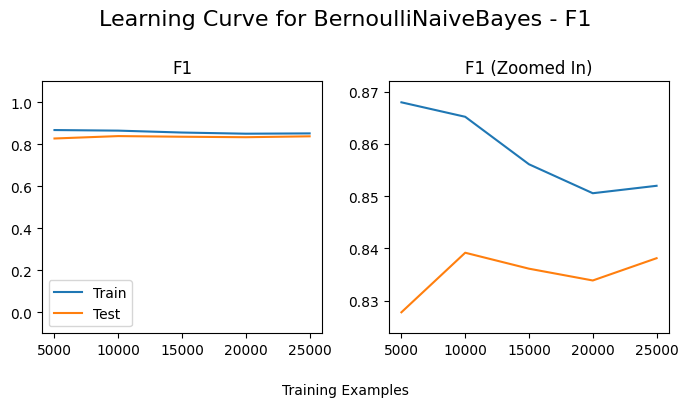

In [53]:
from sklearn.metrics import classification_report

# Train the Bernoulli Naive Bayes model on the training data
bnb_data = evaluate_estimator(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Display classification report for the test set
print(classification_report(y_test, bnb_data['test_pred']))

# Plot the confusion matrix for better insight into classification performance (TP, FP, TN, FN)
plot_confusion_matrix(bnb_data['confusion_matrix'], bnb_data['estimator'])

# Display metrics summary table
plot_metrics_table(bnb_data)

# Plot learning curves to visualize training and testing performance
plot_learning_curves(bnb_data)


### Bernoulli Naive Bayes against Sklearn's Bernoulli Naive Bayes

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


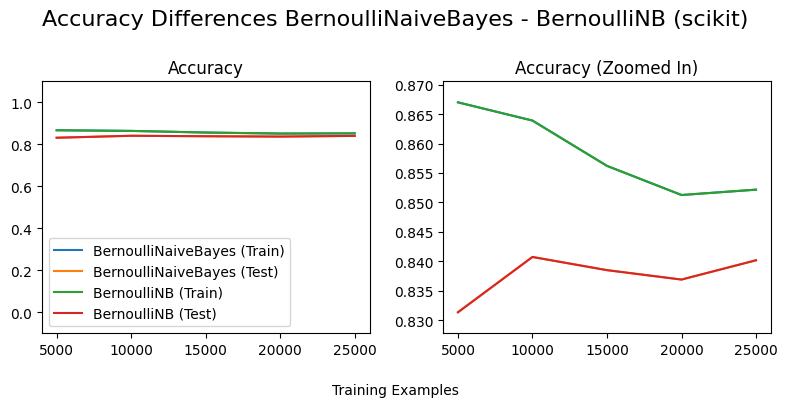

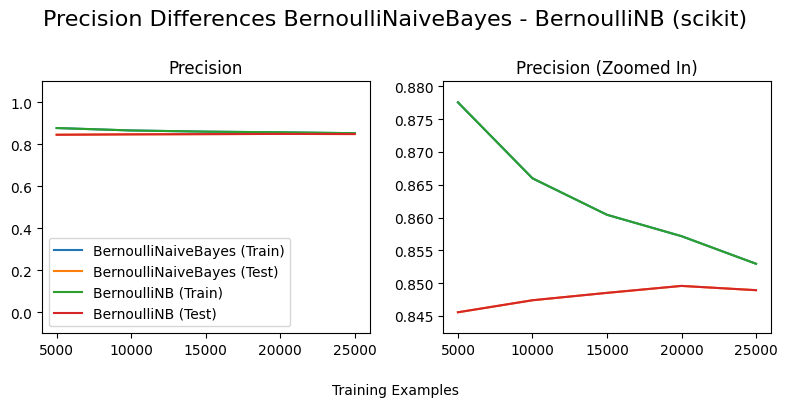

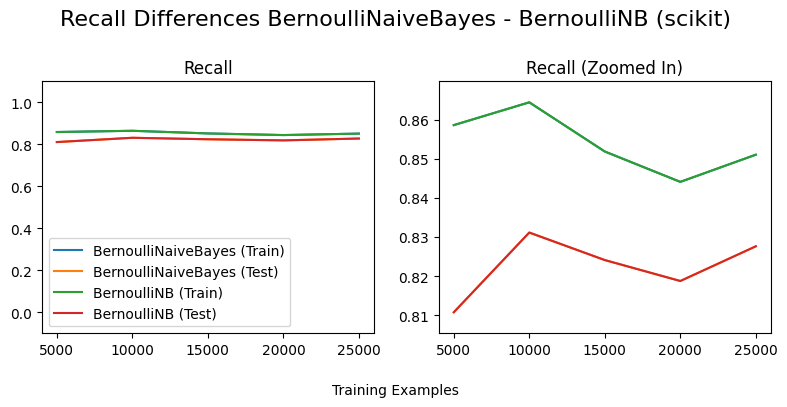

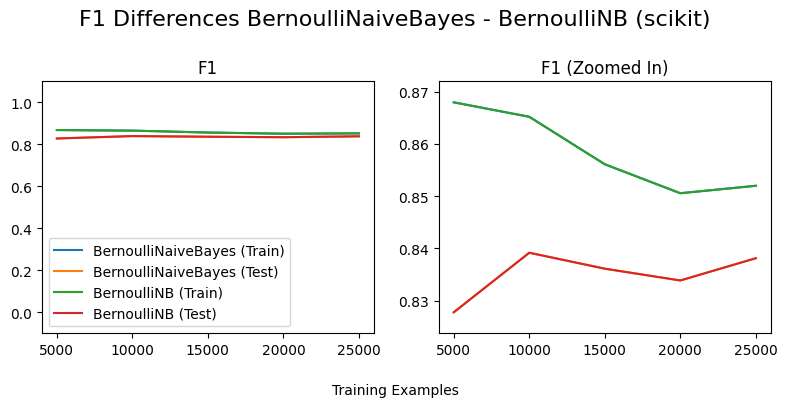

In [31]:
from sklearn.naive_bayes import BernoulliNB

# Evaluate the scikit-learn's Bernoulli Naive Bayes
scikit_bnb_data = evaluate_estimator(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(bnb_data, scikit_bnb_data)
plot_learning_curve_differences(bnb_data, scikit_bnb_data)

### Bernoulli Naive Bayes against Sklearn's Logistic Regression

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.13,0.03,-0.12,0.04,-0.14,0.01,-0.13,0.03
10000,-0.09,0.01,-0.09,0.01,-0.08,0.01,-0.08,0.01
15000,-0.06,0.00,-0.05,0.02,-0.09,-0.04,-0.06,-0.01
20000,-0.06,-0.01,-0.03,0.02,-0.09,-0.05,-0.06,-0.02
25000,-0.05,-0.01,-0.04,0.01,-0.07,-0.05,-0.05,-0.02


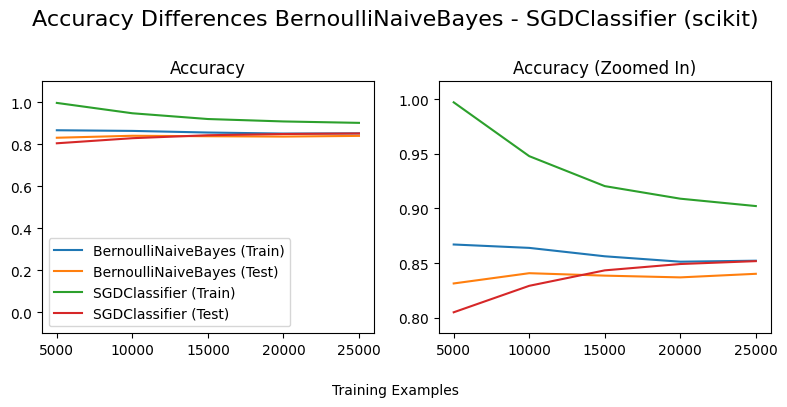

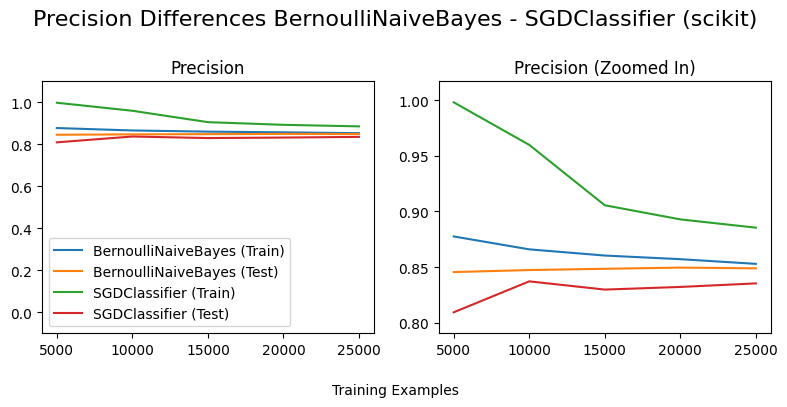

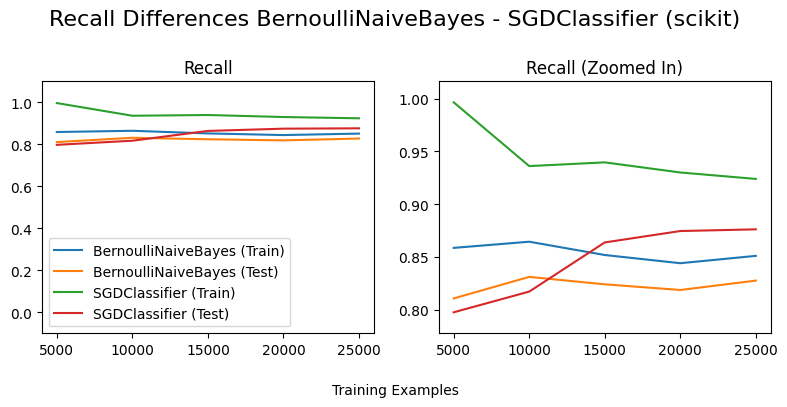

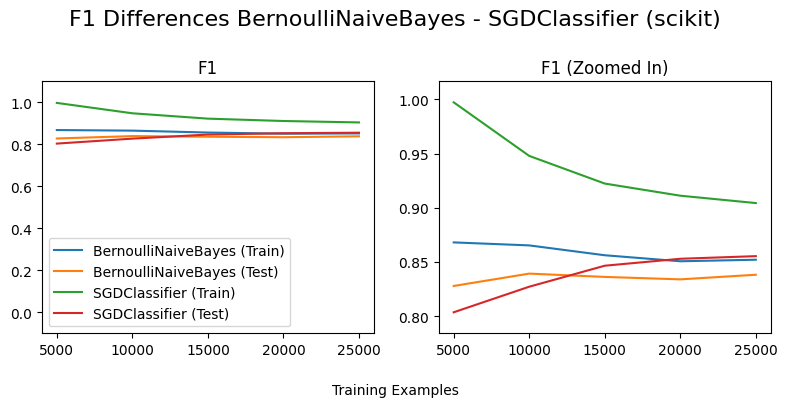

In [36]:
from sklearn.linear_model import SGDClassifier

# Evaluate the scikit-learn's SGDClassifier using log loss (logistic regression)
scikit_logreg_data = evaluate_estimator(SGDClassifier(loss='log_loss'), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(bnb_data, scikit_logreg_data)
plot_learning_curve_differences(bnb_data, scikit_logreg_data)

### Bernoulli Naive Bayes against Sklearn's Random Forest

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.00,0.04,0.07,0.11,-0.11,-0.09,-0.01,0.02
10000,0.01,0.04,0.07,0.10,-0.08,-0.05,0.00,0.03
15000,0.02,0.05,0.07,0.10,-0.09,-0.07,0.00,0.03
20000,0.01,0.04,0.06,0.09,-0.08,-0.06,-0.01,0.01
25000,0.01,0.04,0.06,0.09,-0.07,-0.05,0.00,0.02


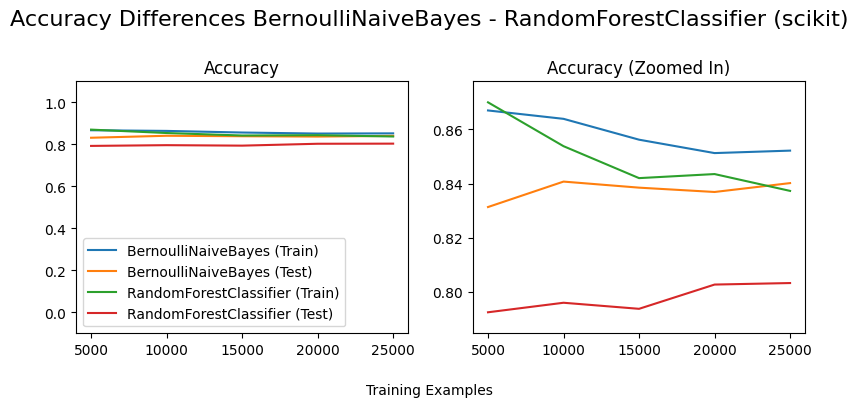

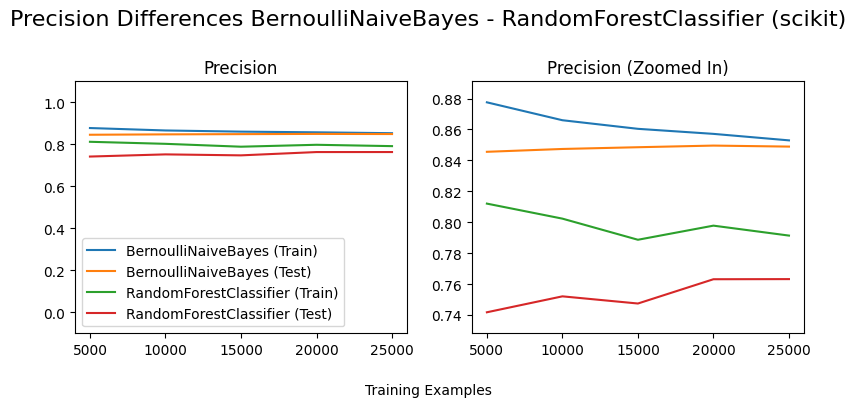

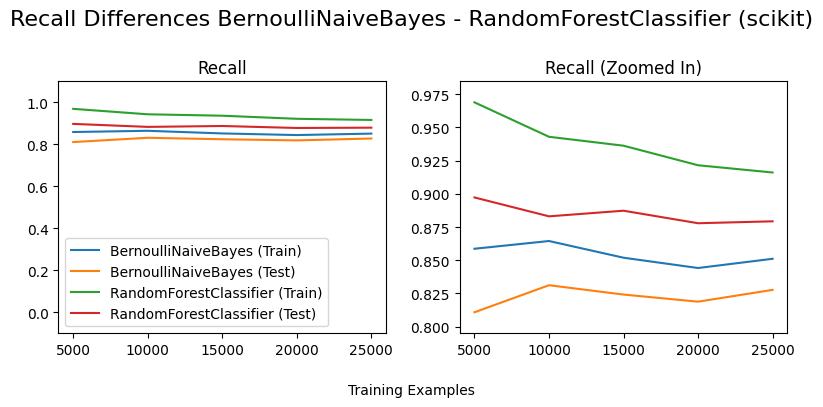

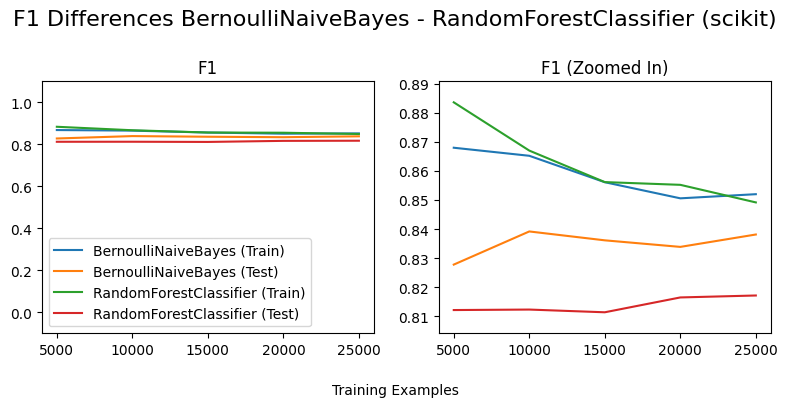

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Evaluate the scikit-learn's RandomForestClassifier
scikit_rf_data = evaluate_estimator(RandomForestClassifier(criterion='entropy', max_depth=10), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(bnb_data, scikit_rf_data)
plot_learning_curve_differences(bnb_data, scikit_rf_data)

### Bernoulli Naive Bayes against Sklearn's Ada Boost

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.07,0.06,0.11,0.11,-0.01,-0.04,0.05,0.04
10000,0.06,0.06,0.10,0.11,-0.01,-0.02,0.06,0.05
15000,0.07,0.06,0.10,0.10,-0.01,-0.03,0.06,0.04
20000,0.06,0.06,0.10,0.10,-0.02,-0.03,0.04,0.03
25000,0.06,0.06,0.09,0.10,-0.01,-0.02,0.05,0.04


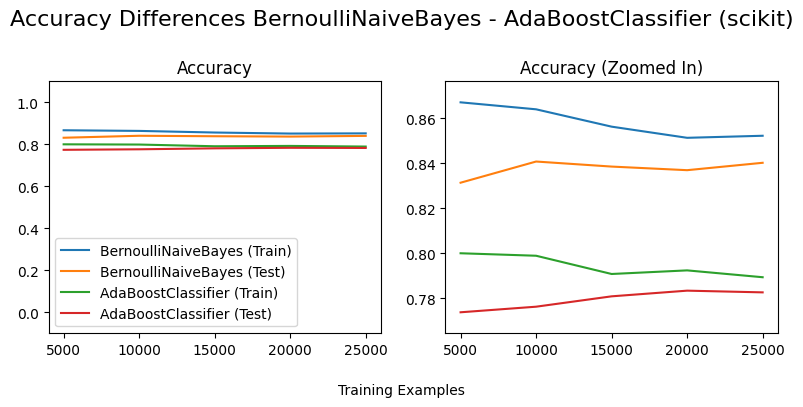

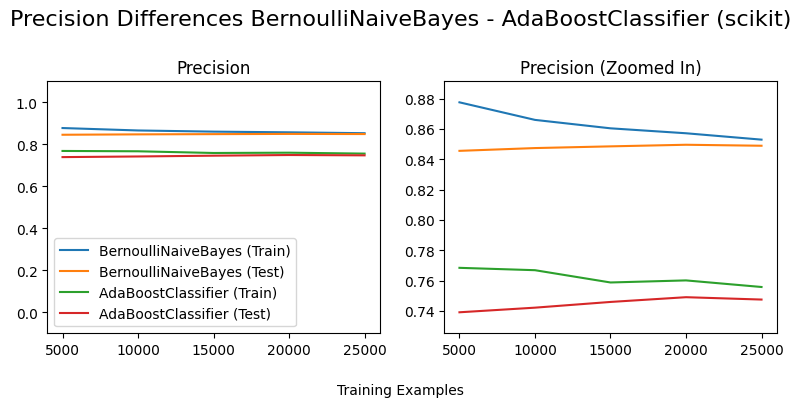

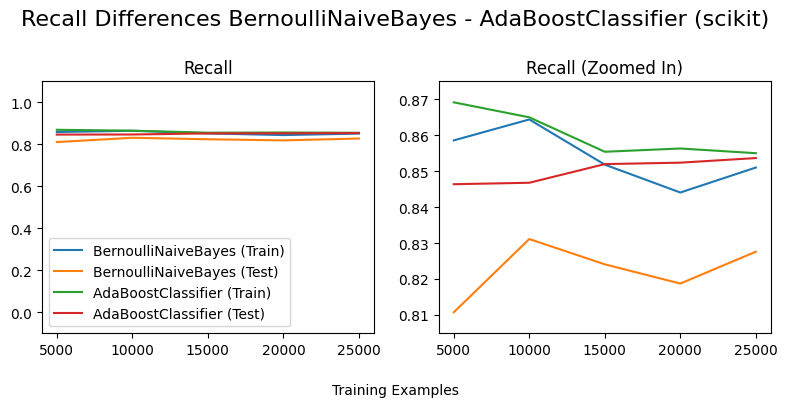

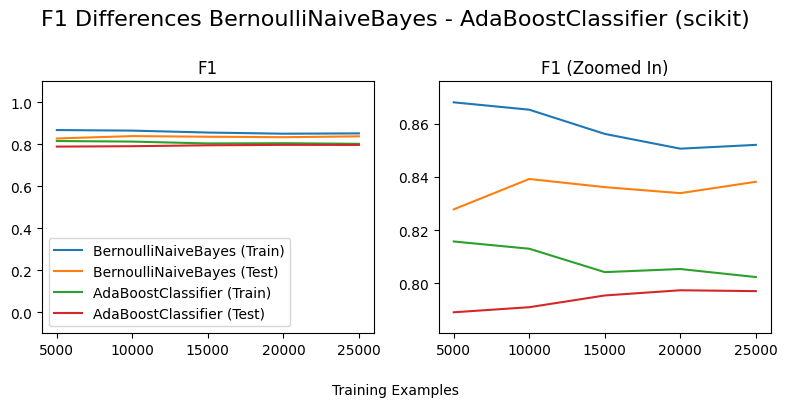

In [40]:
from sklearn.ensemble import AdaBoostClassifier

# Evaluate the scikit-learn's AdaBoostClassifier
scikit_ab_data = evaluate_estimator(AdaBoostClassifier(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(bnb_data, scikit_ab_data)
plot_learning_curve_differences(bnb_data, scikit_ab_data)